<a href="https://colab.research.google.com/github/matt-fidelis-95/X-Ray-Covid-Detector/blob/master/Atividade_IA_mestrado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import urllib.request
import os
from PIL import Image,ImageStat
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F

main_dir = "/content/gdrive/My Drive/datasets/X-Ray Image DataSet"
os.chdir(main_dir)

In [ ]:
!pwd

/content/gdrive/My Drive/datasets/X-Ray Image DataSet


# Carregando os dados em um dataloader

In [ ]:
def image_loader(img):
    return Image.open(img).convert('RGB')

In [ ]:
image_loader = lambda x: Image.open(x).convert('RGB')

In [ ]:
class ToNorm(object):
    def __call__(self,img):
        mean = torch.mean(img)
        std  = torch.std(img)
        return (img - mean)/std

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                ToNorm()
                            ])

In [ ]:
dataset = torchvision.datasets.DatasetFolder(main_dir,loader = image_loader,extensions=('jpg','jpeg','png'),transform=transform )

In [ ]:
dataset.class_to_idx['No_findings']

1

In [ ]:
dl = DataLoader(dataset,batch_size=32)

In [ ]:
data,class_att = next(iter(dl))

In [ ]:
grid_img = torchvision.utils.make_grid(data,nrow=5)

In [ ]:
grid_img.shape

torch.Size([3, 1808, 1292])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


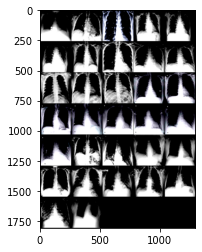

In [ ]:
plt.imshow(grid_img.permute(1,2,0))

# Construção de rede convolucional

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),
        
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=1, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
           
            nn.Conv2d(in_channels=256,out_channels=128,kernel_size=1, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=1,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
 
            nn.Conv2d(in_channels=256,out_channels=3,kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),

            nn.Flatten()
        );
        self.classifier = nn.Sequential(   
        nn.Linear(507, 3)
        )
    def forward(self,x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
model = LeNet5()

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
x = torch.tensor(np.ones(10))
y = torch.tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
skf = StratifiedKFold(n_splits=5)

In [ ]:
for train, test in skf.split(x, y):
    print(train,test)

[1 2 3 5 6 7 8 9] [0 4]
[0 2 3 4 6 7 8 9] [1 5]
[0 1 3 4 5 7 8 9] [2 6]
[0 1 2 4 5 6 8 9] [3 7]
[0 1 2 3 4 5 6 7] [8 9]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
def data_split(dataset,lists):
    return [torch.utils.data.Subset(dataset, llist ) for llist in lists]

In [ ]:
model

LeNet5(
  (backbone): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(16, 

In [ ]:
#for p in model.modules():
#    if isinstance(p, nn.Linear) or isinstance(p,nn.Conv2d):
#        nn.init.kaiming_normal_(p.weight, mode='fan_out', nonlinearity='relu')


In [ ]:
import torchsummary

In [ ]:
torchsummary.summary(model,(3,256,256),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             216
       BatchNorm2d-2          [-1, 8, 256, 256]              16
         LeakyReLU-3          [-1, 8, 256, 256]               0
         MaxPool2d-4          [-1, 8, 128, 128]               0
            Conv2d-5         [-1, 16, 128, 128]           1,152
       BatchNorm2d-6         [-1, 16, 128, 128]              32
         LeakyReLU-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
            Conv2d-9           [-1, 32, 64, 64]           4,608
      BatchNorm2d-10           [-1, 32, 64, 64]              64
        LeakyReLU-11           [-1, 32, 64, 64]               0
           Conv2d-12           [-1, 16, 66, 66]             512
      BatchNorm2d-13           [-1, 16, 66, 66]              32
        LeakyReLU-14           [-1, 16,

# Agora vamos treiná-la

In [ ]:
import torch.optim as optim

In [ ]:
!pip install --upgrade wandb
!wandb login 94dd02310d3352a1eb5de99f052897610a3c0fb6

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.9.1)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [ ]:

def train_model(dl,model,opt,criterion,epochs,device):
    model.to(device)
    model.train()
    lloss = []
    for epoch in range(epochs):
        for x,y in dl:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            lloss.append(loss.item())
        wandb.log({'training loss':np.mean(lloss)})
        


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def evaluate(dl,model,criterion):
    model.to(device)
    model.eval()
    lacc  = []
    lloss = []
    with torch.no_grad():
        for x,y in dl:
            x = x.to(device)
            pred = model(x)
            loss = criterion(pred,y.to(device)) 
            y_pred = pred.argmax(dim=1).cpu()
            acc = accuracy_score(y,y_pred)
            lacc.append(acc)
            lloss.append(loss.item())
    return np.mean(lacc),np.mean(lloss)


In [ ]:
import wandb
lacc = []
device = torch.device('cuda:0')
wandb.init(project="aula")
wandb.watch(model)
for train, test in skf.split(range(len(dataset)), dataset.targets):
    ds_train,ds_test = data_split(dataset,(train,test))
    

    model = LeNet5()
    #for p in model.modules():
    #  if isinstance(p, nn.Linear) or isinstance(p,nn.Conv2d):
    #     nn.init.kaiming_normal_(p.weight, mode='fan_out', nonlinearity='relu')
    #model = torchvision.models.mobilenet_v2(pretrained=True)
    #model.classifier[1] = nn.Linear(1280,2) 
    
    criterion  = nn.CrossEntropyLoss()
    opt   = optim.Adam(model.parameters(),lr=0.003)
    
    dl_train = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True)
    dl_test  = torch.utils.data.DataLoader(ds_test,batch_size=32, shuffle=False)
    
    train_model(dl_train,model,opt,criterion,100,device)
    (acc,loss)=evaluate(dl_test,model,criterion)
    wandb.log({'dev loss':loss,'dev acc':acc})
    print("accuracy:%4.3f loss:%4.3f"%(acc,loss))
    torch.save(model.state_dict(),'model.pth')
    lacc.append(acc)
np.mean(lacc),np.std(lacc)

accuracy:0.828 loss:0.904
accuracy:0.770 loss:1.310
accuracy:0.789 loss:1.037
accuracy:0.797 loss:1.015
accuracy:0.691 loss:1.078


(0.775, 0.04586143787949741)